# Isochrone Fitting (SU2023)
This notebook is created in summer 2023 for more isochrone fitting & plotting. The goal is to test isochrone fitting on both rapid and slow rotators.

In [146]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os
import random
from astroquery.simbad import Simbad
from uncertainties import ufloat,unumpy
from uncertainties.umath import *
import pandas as pd
import csv


from isochrones.mist import MIST_EvolutionTrack, MIST_Isochrone
Mist_iso = MIST_Isochrone()
Mist_evoTrack = MIST_EvolutionTrack()

%matplotlib inline

In [147]:
matplotlib.rcParams['figure.figsize'] = (8, 5)
matplotlib.rcParams['font.family'] = "Times New Roman"
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['lines.markerfacecolor'] = 'black'
matplotlib.rcParams['lines.linewidth'] = 3.5

In [148]:
## Add quantities of interest to Simbad query -- for total magnitudes
##
## This is a good first check, but for for each target we will eventually 
## want to do a deeper literature search to make sure we are using 
## all available photometry. We should record this in the spreadsheet.

Simbad.add_votable_fields('flux(U)')
Simbad.add_votable_fields('flux(B)')
Simbad.add_votable_fields('flux(V)')
Simbad.add_votable_fields('flux(G)')
Simbad.add_votable_fields('flux(R)')
Simbad.add_votable_fields('flux(I)')
Simbad.add_votable_fields('flux(J)')
Simbad.add_votable_fields('flux(H)')
Simbad.add_votable_fields('flux(K)')

Simbad.add_votable_fields('flux_error(U)')
Simbad.add_votable_fields('flux_error(B)')
Simbad.add_votable_fields('flux_error(V)')
Simbad.add_votable_fields('flux_error(G)')
Simbad.add_votable_fields('flux_error(R)')
Simbad.add_votable_fields('flux_error(I)')
Simbad.add_votable_fields('flux_error(J)')
Simbad.add_votable_fields('flux_error(H)')
Simbad.add_votable_fields('flux_error(K)')

In [149]:
## Setup paths
dirpath = "/Users/suzutsuki-ch/Work/ARMADA/"
save_directory = "/Users/suzutsuki-ch/Work/ARMADA/Targets" ## path for saved files
armada_file = "/Users/suzutsuki-ch/Work/ARMADA/full_target_list_426.csv" ## path to csv target file
note = 'Chi' ## note for saved files (e.g. 'hip' for hipparcos distance, or 'gaia')

In [150]:
target_hd = '189037'
df = pd.read_csv(armada_file,dtype=object)

## Create directory for saved files, if it doesn't already exist
directory = "%s/HD_%s/"%(save_directory,target_hd)
if not os.path.exists(directory):
    print("Creating directory")
    os.makedirs(directory)

In [151]:
df.columns

Index(['HD', 'HIP', 'P (yr)', 'P_err (yr)', 'a (mas)', 'a_err (mas)', 'e',
       'e_err', 'i (deg)', 'i_err (deg)', 'w (deg)', 'w_err (deg)',
       'bigw (deg)', 'bigw_err (deg)', 'T (mjd)', 'T_err (mjd)',
       'residual (micro-as)', 'binary_separation (mas)', 'HIP_distance (pc)',
       'HIP_distance_err (pc)', 'Gaia_distance (pc)', 'Gaia_distance_err (pc)',
       'a_HIP (au)', 'a_HIP_err (au)', 'a_Gaia (au)', 'a_Gaia_err (au)',
       'Mdyn_HIP (Msun)', 'Mdyn_HIP_err (Msun)', 'Mdyn_Gaia (Msun)',
       'Mdyn_Gaia_err (Msun)', 'Mdyn_over_d3 (x10e-6)',
       'Mdyn_over_d3_err (x10e-6)', 'triple', 'SpType (primary?)',
       'dmag_speckle_v', 'dmag_speckle_v_err', 'dmag_speckle_i',
       'dmag_speckle_i_err', 'dmag_wds_v', 'dmag_wds_v_err', 'dmag_h',
       'dmag_h_err', 'dmag_k', 'dmag_k_err', 'M1_ph', 'M2_ph', 'Msum_ph',
       'Diameters', 'complete vsini', 'vsini', 'Gaia vsini', 'Gaia Teff',
       'Gaia e_plx', 'Gaia Fe/H', 'Gaia Dist', 'Complete[Fe/H]', 'G-C [Fe/H]',
      

In [152]:
idx = np.where(df['HD']==target_hd)[0][0]

distance_gaia = ufloat(float(df['Gaia_distance (pc)'][idx]),float(df['Gaia_distance_err (pc)'][idx]))
distance_hip = ufloat(float(df['HIP_distance (pc)'][idx]),float(df['HIP_distance_err (pc)'][idx]))
print("distance gaia = ",distance_gaia)
print("distance hip = ",distance_hip)


cdiff_h = ufloat(float(df['dmag_h'][idx]),float(df['dmag_h_err'][idx]))
cdiff_k = ufloat(float(df['dmag_k'][idx]),float(df['dmag_k_err'][idx]))
cdiff_i = ufloat(float(df['dmag_speckle_i'][idx]),float(df['dmag_speckle_i_err'][idx]))
cdiff_v_speckle = ufloat(float(df['dmag_speckle_v'][idx]),float(df['dmag_speckle_v_err'][idx]))
cdiff_v_wds = ufloat(float(df['dmag_wds_v'][idx]),float(df['dmag_wds_v_err'][idx]))

distance gaia =  nan+/-nan
distance hip =  86.3+/-2.8


In [153]:
fratio_h = 10**(cdiff_h/2.5)
fratio_k = 10**(cdiff_k/2.5)
fratio_i = 10**(cdiff_i/2.5)
fratio_v_speckle = 10**(cdiff_v_speckle/2.5)
fratio_v_wds = 10**(cdiff_v_wds/2.5)

print("fratio: v_speckle, v_wds, i_mag, h_mag, k_mag = ")
print(fratio_v_speckle,',',fratio_v_wds,',',fratio_i,',',fratio_h,',',fratio_k)

fratio: v_speckle, v_wds, i_mag, h_mag, k_mag = 
1.74+/-0.24 , 1.58+/-0.12 , 1.51+/-0.21 , 1.82+/-0.27 , nan+/-nan


## Generating SED for individual components

In [154]:
cdiff_h## query total magnitudes and errors from Simbad
query = Simbad.query_object('HD %s'%target_hd)

ktot = ufloat(query['FLUX_K'][0],query['FLUX_ERROR_K'][0])
utot = ufloat(query['FLUX_U'][0],query['FLUX_ERROR_U'][0])
btot = ufloat(query['FLUX_B'][0],query['FLUX_ERROR_B'][0])
rtot = ufloat(query['FLUX_R'][0],query['FLUX_ERROR_R'][0])
itot = ufloat(query['FLUX_I'][0],query['FLUX_ERROR_I'][0])
htot = ufloat(query['FLUX_H'][0],query['FLUX_ERROR_H'][0])
jtot = ufloat(query['FLUX_J'][0],query['FLUX_ERROR_J'][0])
vtot = ufloat(query['FLUX_V'][0],query['FLUX_ERROR_V'][0])
gtot = ufloat(query['FLUX_G'][0],query['FLUX_ERROR_G'][0])


print("U,B,V,R,Gaia_G,I,J,H,K = ")
print(utot,',',btot,',',vtot,',',rtot,',',gtot,',',itot,',',jtot,',',htot,',',ktot)

U,B,V,R,Gaia_G,I,J,H,K = 
nan+/-nan , 5.120+/-0.010 , 5.020+/-0.010 , nan+/-nan , 4.933+/-0.004 , nan+/-nan , 4.52+/-0.25 , 4.604+/-0.034 , 4.492+/-0.016


/Users/suzutsuki-ch/opt/anaconda3/envs/isochrones/lib/python3.10/site-packages/uncertainties/core.py:2766: UserWarning: Warning: converting a masked element to nan.
  value = float(value)
/Users/suzutsuki-ch/opt/anaconda3/envs/isochrones/lib/python3.10/site-packages/uncertainties/core.py:2801: UserWarning: Warning: converting a masked element to nan.
  self._std_dev = CallableStdDev(std_dev)


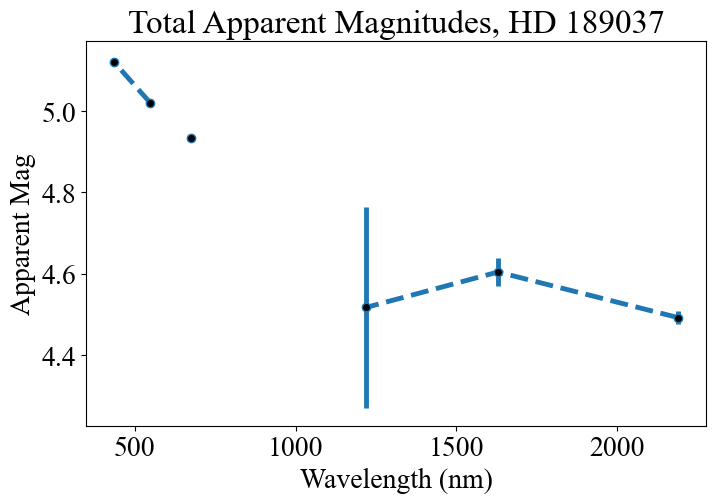

In [155]:
x = np.array([2190,1630,1220,832,673,658,547.7,435.3,365.6]) ## central wavelengths of Simbad magnitudes chosen above
y = np.array([ktot.nominal_value,htot.nominal_value,jtot.nominal_value,itot.nominal_value,
              gtot.nominal_value,rtot.nominal_value,vtot.nominal_value,
              btot.nominal_value,utot.nominal_value])
yerr = np.array([ktot.std_dev,htot.std_dev,jtot.std_dev,itot.std_dev,gtot.std_dev,
                 rtot.std_dev,vtot.std_dev,btot.std_dev,utot.std_dev])

plt.title("Total Apparent Magnitudes, HD %s"%target_hd)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Apparent Mag")
plt.errorbar(x,y,yerr,fmt='o--')
plt.savefig("%s/HD_%s_%s_total_mags.pdf"%(directory,target_hd,""), transparent=True)
plt.show()

In [156]:
x_notnan = np.array([2190,1630,1220,673,547.7,435.3,365.6]) ## central wavelengths of Simbad magnitudes chosen above
y_notnan = np.array([ktot.nominal_value,htot.nominal_value,jtot.nominal_value,gtot.nominal_value,vtot.nominal_value,
              btot.nominal_value,utot.nominal_value])

In [157]:
data_wave = np.array([551,562,832,1630,2190]) ## wavelengths of our speckle + interferometry data, CHECK THESE

## Compute individual magnitudes from flux ratios and total magnitudes
## Mostly for plotting. We probably won't fit to these in the end. 

k1 = -2.5*log10(10**(-ktot/2.5)/(1+10**(-cdiff_k/2.5)))
k2 = cdiff_k + k1

h1 = -2.5*log10(10**(-htot/2.5)/(1+10**(-cdiff_h/2.5)))
h2 = cdiff_h + h1

# This line is for visualizing the SED. 
# Though Gaia G does have some overlap with speckle_i, I believe we should not use this in fitting
i1 = -2.5*log10(10**(-gtot/2.5)/(1+10**(-cdiff_i/2.5)))
i2 = cdiff_i + i1

v_speckle1 = -2.5*log10(10**(-vtot/2.5)/(1+10**(-cdiff_v_speckle/2.5)))
v_speckle2 = cdiff_v_speckle + v_speckle1

v_wds1 = -2.5*log10(10**(-vtot/2.5)/(1+10**(-cdiff_v_wds/2.5)))
v_wds2 = cdiff_v_wds + v_wds1

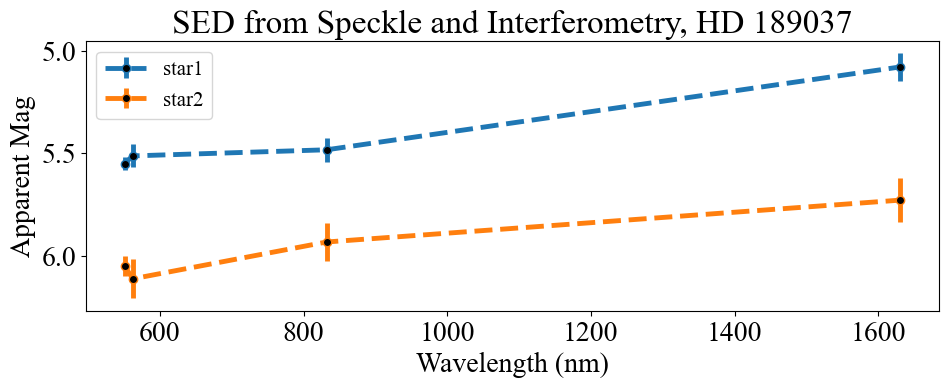

In [158]:
p1 = np.array([v_wds1.nominal_value,v_speckle1.nominal_value,i1.nominal_value,h1.nominal_value,k1.nominal_value])
p1err = np.array([v_wds1.std_dev,v_speckle1.std_dev,i1.std_dev,h1.std_dev,k1.std_dev])
p2 = np.array([v_wds2.nominal_value,v_speckle2.nominal_value,i2.nominal_value,h2.nominal_value,k2.nominal_value])
p2err = np.array([v_wds2.std_dev,v_speckle2.std_dev,i2.std_dev,h2.std_dev,k2.std_dev])

plt.figure(figsize=(11,3.5))
plt.title("SED from Speckle and Interferometry, HD %s"%target_hd)
plt.errorbar(data_wave,p1,p1err,fmt='o--', label="star1")
plt.errorbar(data_wave,p2,p2err,fmt='o--', label="star2")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Apparent Mag')
plt.legend(fontsize=15)
plt.gca().invert_yaxis()
plt.savefig("%s/HD_%s_%s_split_mags.pdf"%(directory,target_hd,note), dpi=240, bbox_inches="tight", transparent=True)
plt.show()

## Generating 

In [159]:
import tqdm

In [160]:
# This cell fails at its initial run, please run it again if error is thrown

feh = 0 ## we will want to look up this value for each target
Av = 0.0 ## targets are nearby, so extinction should be negligible

log_age_start = 6 ## starting age
log_age_size = 0.5 ## step size
log_age_steps = 7 ## number of steps

try:
    paramList  = [np.array([log_age_start,feh])+np.array([log_age_size,0])*i for i in range(0,log_age_steps)]

    isoList = [Mist_iso.isochrone(param[0],param[1]) for param in paramList] 
    isoList[0].head()
except:
    paramList  = [np.array([log_age_start,feh])+np.array([log_age_size,0])*i for i in range(0,log_age_steps)]

    isoList = [Mist_iso.isochrone(param[0],param[1]) for param in paramList] 
    isoList[0].head()

/Users/suzutsuki-ch/opt/anaconda3/envs/isochrones/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/suzutsuki-ch/opt/anaconda3/envs/isochrones/lib/python3.10/site-packages/isochrones/models.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.loc[:, "dm_deep"] = deriv


In [161]:
from isochrones.mist.bc import MISTBolometricCorrectionGrid
bc_grid_B = MISTBolometricCorrectionGrid(['B'])
bc_grid_V = MISTBolometricCorrectionGrid(['V'])
bc_grid_I = MISTBolometricCorrectionGrid(['I'])

In [162]:
# Calculating the bolometric correction in B band
Mbol_B = []
for i,iso in enumerate(isoList):
    Mbol_B.append(bc_grid_B.interp([iso['Teff'], iso['logg'], feh, Av]).ravel())   
B = []
for i,iso in enumerate(isoList):
    B.append(iso['Mbol'] - Mbol_B[i])
    
# Calculating the bolometric correction in V band
Mbol_V = []
for i,iso in enumerate(isoList):
    Mbol_V.append(bc_grid_V.interp([iso['Teff'], iso['logg'], feh, Av]).ravel())  
V = []
for i,iso in enumerate(isoList):
    V.append(iso['Mbol'] - Mbol_V[i])

# Calculating the bolometric correction in I band
Mbol_I = []
for i,iso in enumerate(isoList):
    Mbol_I.append(bc_grid_I.interp([iso['Teff'], iso['logg'], feh, Av]).ravel())  
I = []
for i,iso in enumerate(isoList):
    I.append(iso['Mbol'] - Mbol_I[i])
    
H = []
for iso in isoList:
    H.append(iso['H_mag'])

K = []
for iso in isoList:
    K.append(iso['K_mag'])

In [163]:
distance_gaia = ufloat(float(df['Gaia_distance (pc)'][idx]),float(df['Gaia_distance_err (pc)'][idx]))
distance_hip = ufloat(float(df['HIP_distance (pc)'][idx]),float(df['HIP_distance_err (pc)'][idx]))
print("distance gaia = ",distance_gaia)
print("distance hip = ",distance_hip)

distance gaia =  nan+/-nan
distance hip =  86.3+/-2.8


In [164]:
distance = distance_hip

In [165]:
print("Distance = ", distance, 'pc')
d_modulus = 5*log10(distance)-5
print("Distance Modulus = ", d_modulus)

Distance =  86.3+/-2.8 pc
Distance Modulus =  4.68+/-0.07


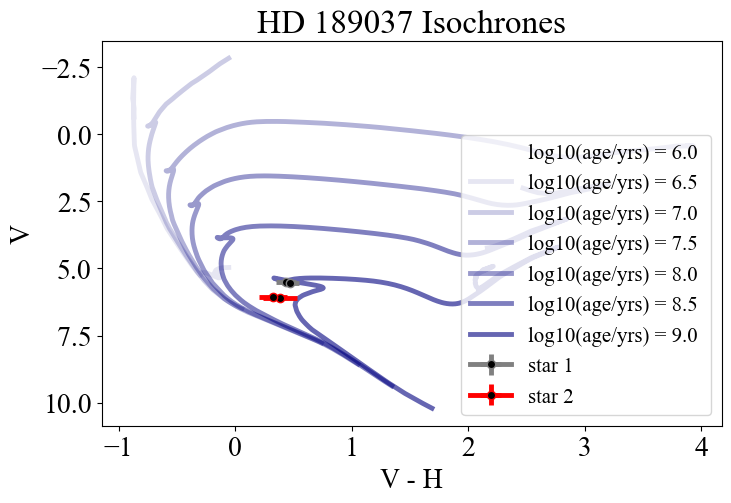

In [166]:
## change the range of plotted values in isochrones "by eye"
iso_start = 100
iso_end = 500


## Choose x/y axis. For example, V-H vs V
xval1 =v_speckle1-h1 ## component 1
yval1 = v_speckle1
xval2 = v_speckle2-h2 ## component 2
yval2 = v_speckle2

xval3 =v_wds1-h1 ## component 1
yval3 = v_wds1
xval4 = v_wds2-h2 ## component 2
yval4 = v_wds2

xlabel = "V - H"
ylabel = "V"

plt.figure(facecolor="None")
for i,iso in enumerate(isoList):
    
    ## make sure model matches data magnitudes
    modelx = V[i][iso_start:iso_end] - H[i][iso_start:iso_end]
    modely = V[i][iso_start:iso_end] + d_modulus.nominal_value
    
    plt.plot(modelx,modely,label = f"log10(age/yrs) = {6+0.5*i} ", color="navy", alpha=1 - (1 - 0.1*i))

## make plot

plt.errorbar([xval1.nominal_value,xval3.nominal_value],[yval1.nominal_value, yval3.nominal_value],
             xerr = [xval1.std_dev,xval3.std_dev], yerr = [yval1.std_dev,yval3.std_dev],
             color="gray", label="star 1", markerfacecolor="black",marker='o')
plt.errorbar([xval2.nominal_value,xval4.nominal_value],[yval2.nominal_value, yval4.nominal_value],
             xerr = [xval2.std_dev,xval4.std_dev], yerr = [yval2.std_dev,yval4.std_dev],
             color="red", label="star 2", markerfacecolor="black",marker='o')

        
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.gca().invert_yaxis()
plt.title("HD %s Isochrones"%target_hd)
plt.legend(fontsize=15,loc=4)
plt.savefig("%s/HD_%s_%s_hr_diagram.png"%(directory,target_hd,note), dpi=240, bbox_inches="tight")
plt.show()